In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

#sparkql query to get the country name and their respective quids from wikidata
query = """#List of present-day countries and capital(s)
SELECT DISTINCT ?country ?countryLabel
WHERE
{
  ?country wdt:P31 wd:Q3624078 .

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
ORDER BY ?countryLabel"""

'''
query internet dataset:
endpoint_url (string): url of corresponding dataset
query (string): sparksql query
'''
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

#Build a country dictionnary {quid, country name}
country_dict = {}
for result in results["results"]["bindings"]:
    country_id = result["country"]['value'].split('/')[-1]
    country_dict[country_id] = result["countryLabel"]['value']
# country_dict.to_pickle('data/country_dict.bz2', compression="bz2")

In [3]:
path_us = 'data/'

politician_id = 'Q82955'
cols_of_interest = ['quoteID', 'speaker', 'qids', 'sentiment']


In [4]:

dfs = []
for i in range(2015, 2021):
    df_full = pd.read_pickle(path_us + "us_" + str(i) + ".pkl.bz2",compression='bz2')[cols_of_interest]
    
    df_sent = pd.read_pickle(path_us + "us_weighted_sent_" + str(i) + '.pkl.bz2',compression='bz2')
    print("length df_sent: ",len(df_sent))
    df_all = pd.merge(df_full.copy(), df_sent.copy(), left_on=['quoteID'], right_on=['quoteID'], how='inner')
    length = len(df_all)
    dfs.append(df_all.copy())
    print(str(i) + " loaded, length ",length )
    df_full = None
    df_all =None
    df_sent = None

length df_sent:  626278
2015 loaded, length  626278
length df_sent:  571920
2016 loaded, length  571920
length df_sent:  1004632
2017 loaded, length  1004632
length df_sent:  989231
2018 loaded, length  989231
length df_sent:  818838
2019 loaded, length  818838
length df_sent:  219947
2020 loaded, length  219947


In [5]:
speaker_df = pd.read_parquet("data/speaker_attributes.parquet")

In [6]:
speaker_df.drop(columns=['aliases',
       'lastrevid', 
       'US_congress_bio_ID', 'party',
       'label', 'candidacy', 'type'], inplace=True)

In [8]:
# speaker_df

In [9]:
# none_entry = pd.DataFrame([None, ['None'], None, ['None'], None, ],columns=speaker_df.columns)
# speaker_df = speaker_df.append()

In [34]:
def process_qids(x):
    if not x:
        return ["None"]
    return x[0]

dfs_new = []
for df in dfs :
    print(i)
    print("before , length : ",len(df))
    df["speaker_id"] = df.qids.map(process_qids).copy()
    df.drop(columns=['qids'],inplace=True)
    df_1 = pd.merge(df.copy(), speaker_df, left_on=['speaker_id'], right_on=['id'], how='inner')
    print("length df1: ",len(df_1))
    df_1 = df_1.explode('nationality')
    df_1.nationality = df_1.nationality.map(country_dict)
    
    df_1.occupation.fillna(value="None", inplace=True)
    df_1['politician'] = df_1['occupation'].map(lambda x : politician_id in x)
    print("length df1 after_process: ",len(df_1))
    
#     print("length df_all: ",len(df_all))
    dfs_new.append(df_1.copy())
    
#     df_sent = None
    df_1 = None
    df = None
#     df_all = None

# dfs = None

before , length :  626278
length df1:  404582
length df1 after_process:  428307
before , length :  571920
length df1:  356108
length df1 after_process:  373922
before , length :  1004632
length df1:  616161
length df1 after_process:  648315
before , length :  989231
length df1:  611988
length df1 after_process:  643144
before , length :  818838
length df1:  512795
length df1 after_process:  536718
before , length :  219947
length df1:  138204
length df1 after_process:  144148


In [ ]:
#Temporary store 
file_name = 'temp/politic.pkl'
open_file = open(file_name, "wb")

pickle.dump(dfs_new, open_file)

open_file.close()

### After processing

In [12]:
file_name = 'temp/politic.pkl'

In [13]:
with open(file_name, 'rb') as f:
    dfs_new = pickle.load(f)

In [35]:
for (ind, df) in enumerate(dfs_new) :
    ratio_q = len(df[df.politician == True]) / float(len(df))
    print("Percentage of politician's quotes in year " + str(ind + 2015) + ":  " + str(ratio_q * 100) + "%")
    
    ratio_p = len(df[df.politician == True]['speaker_l'].unique()) / float(len(df['speaker_l'].unique()))
    print("Ratio of politicians vs non-politicians in year " + str(ind + 2015) + ":  " + str(ratio_p * 100) + "%")

Percentage of politician's quotes in year 2015: 38.085065151865365%
Ratio of politicians vs non-politicians in year 2015: 12.690181559995942%
Percentage of politician's quotes in year 2016: 40.99063441038505%
Ratio of politicians vs non-politicians in year 2016: 13.961380740647636%
Percentage of politician's quotes in year 2017: 39.72050623539483%
Ratio of politicians vs non-politicians in year 2017: 13.03395754228512%
Percentage of politician's quotes in year 2018: 38.250376276541495%
Ratio of politicians vs non-politicians in year 2018: 13.131521963852407%
Percentage of politician's quotes in year 2019: 41.78302199665374%
Ratio of politicians vs non-politicians in year 2019: 13.208870873445843%
Percentage of politician's quotes in year 2020: 46.01381913033826%
Ratio of politicians vs non-politicians in year 2020: 16.108126841102063%


In [23]:
def compute_mean(df_country):
    #Use the weighted sentiment
    mean = df_country.weighted_sentiment.mean()
    df_mean = pd.DataFrame()
    df_mean["mean"] = mean
    df_mean['country'] = mean.index
    return df_mean

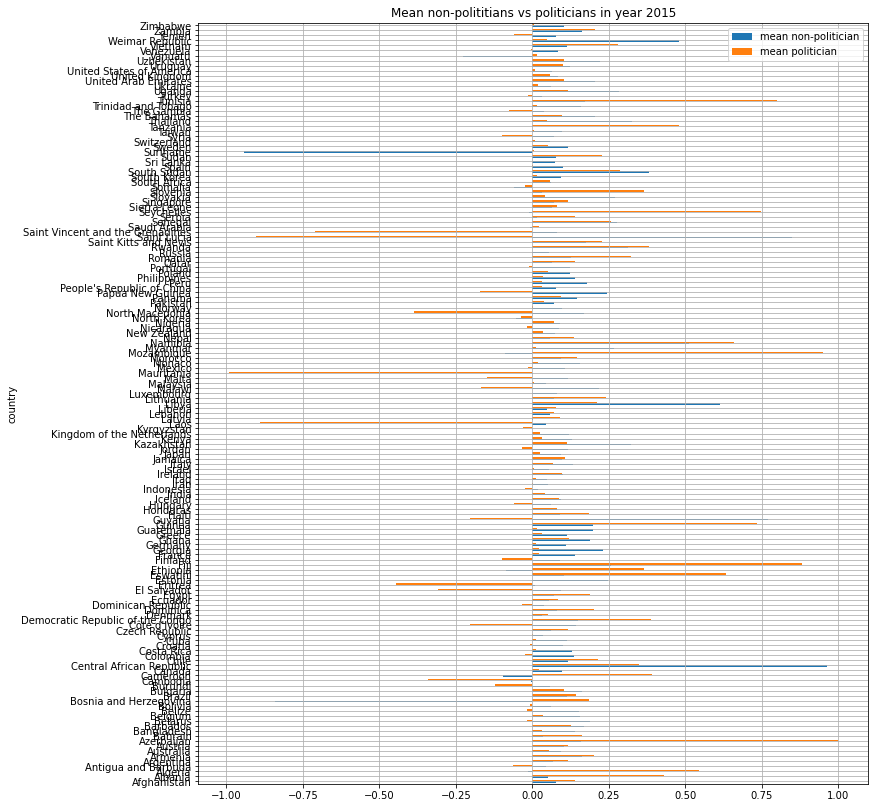

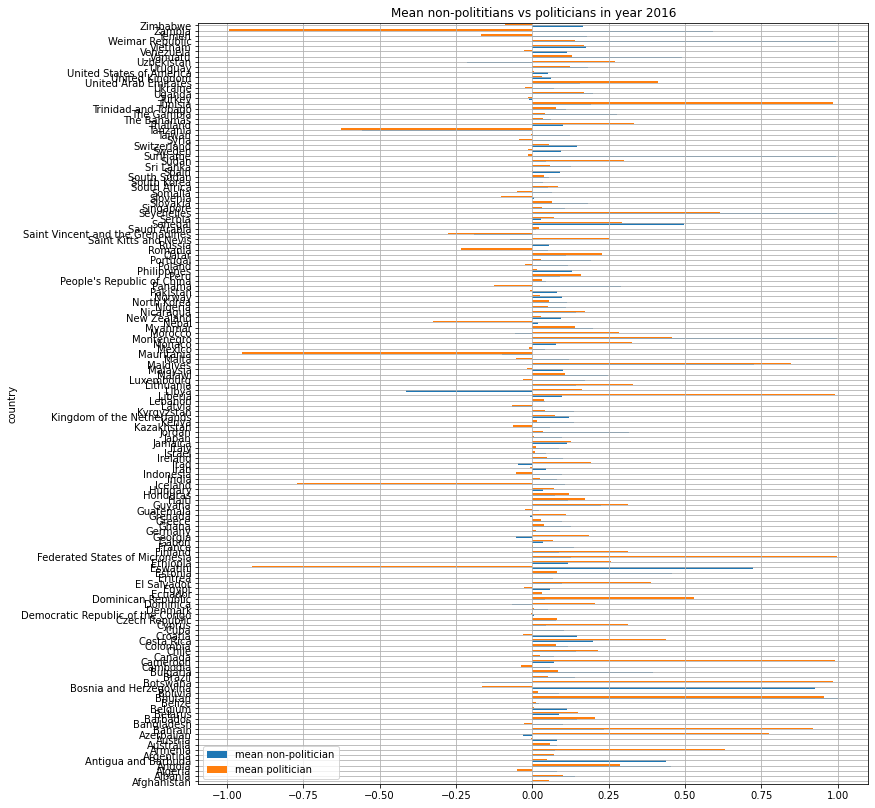

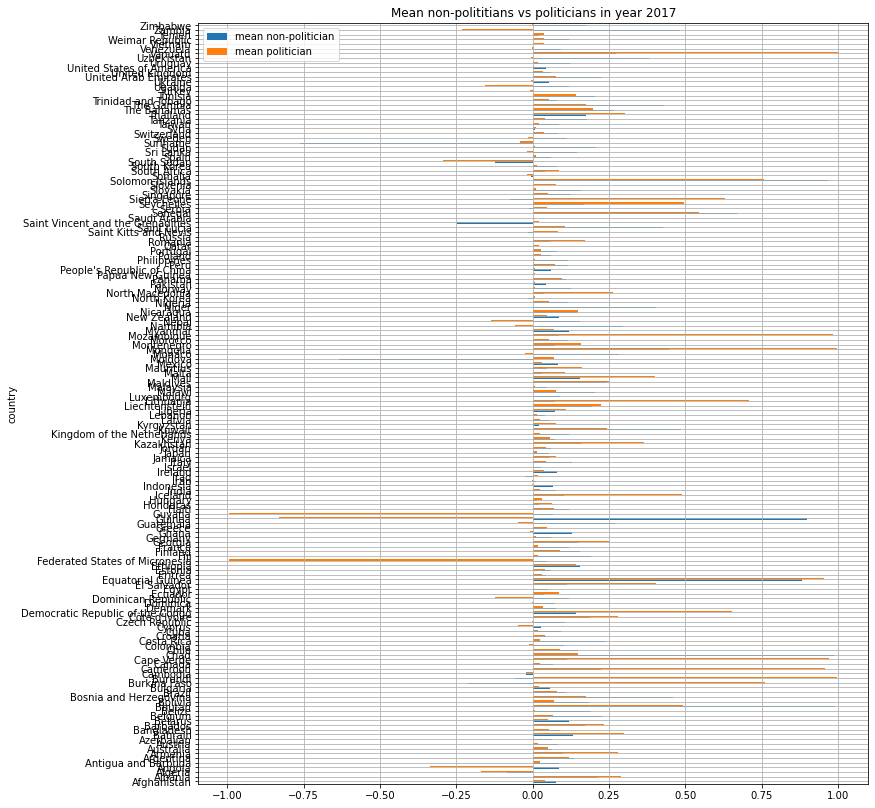

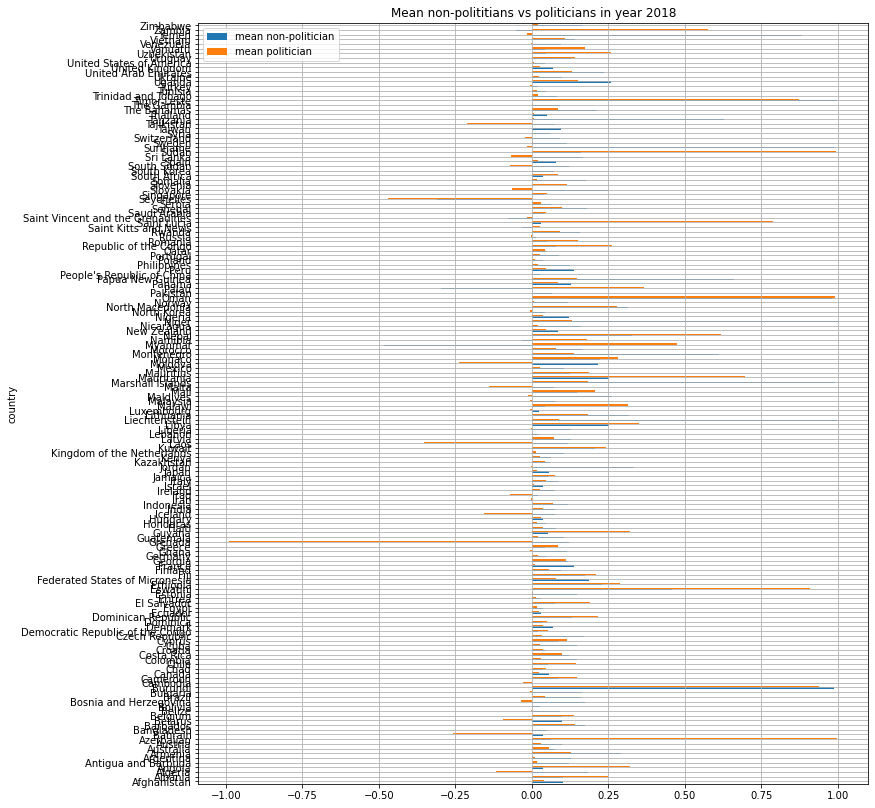

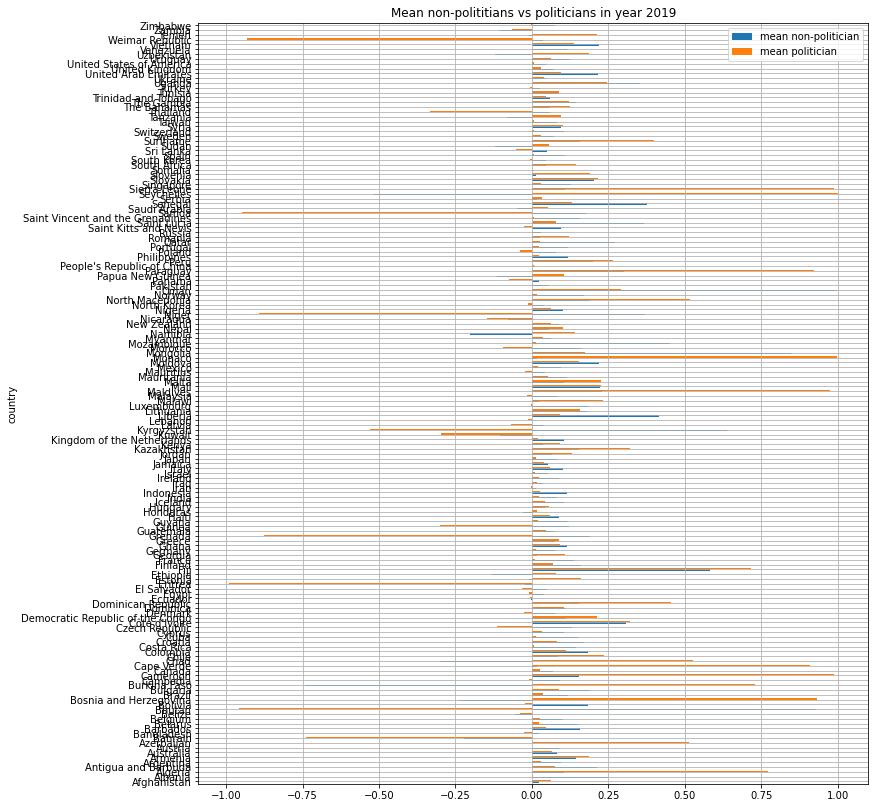

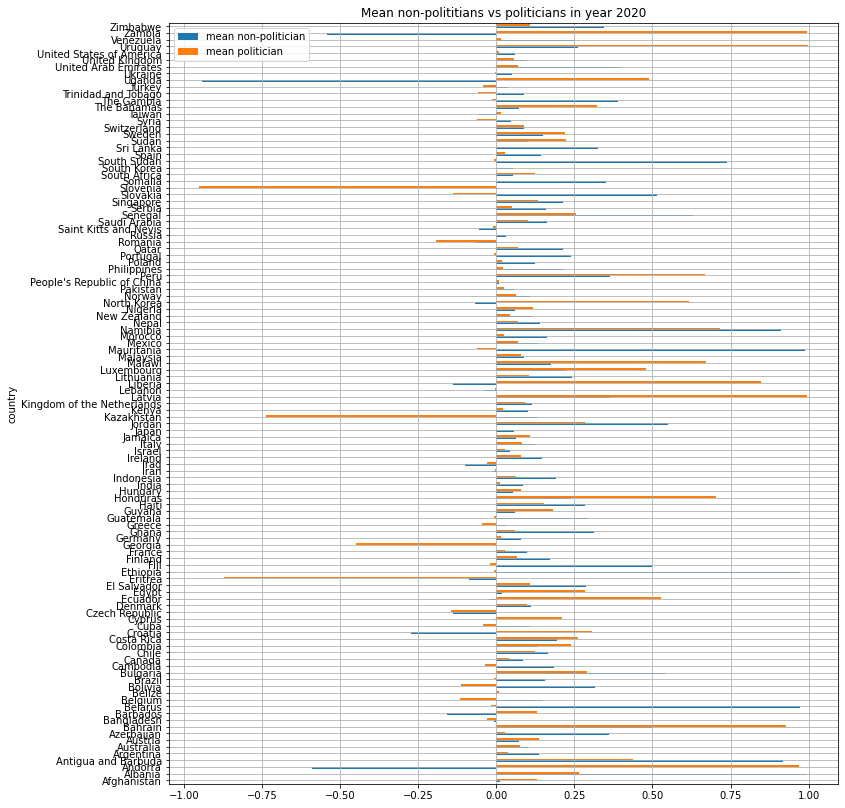

In [36]:

for (ind, df) in enumerate(dfs_new) :

    pol_msk = df.politician == True

    df_country_non_p = df[~pol_msk].groupby("nationality")
    df_country_p = df[pol_msk].groupby("nationality")
    
    df_mean_non_p = compute_mean(df_country_non_p)
    df_mean_p = compute_mean(df_country_p)


    temp_df = pd.merge(left=df_mean_non_p, right=df_mean_p, left_on='country', right_on='country', suffixes=(' non-politician', ' politician'))


    temp_df.plot(x= 'country', figsize=(12,14), kind='barh')
    plt.title("Mean non-polititians vs politicians in year " + str(ind + 2015))
    plt.grid()
    plt.show()
    

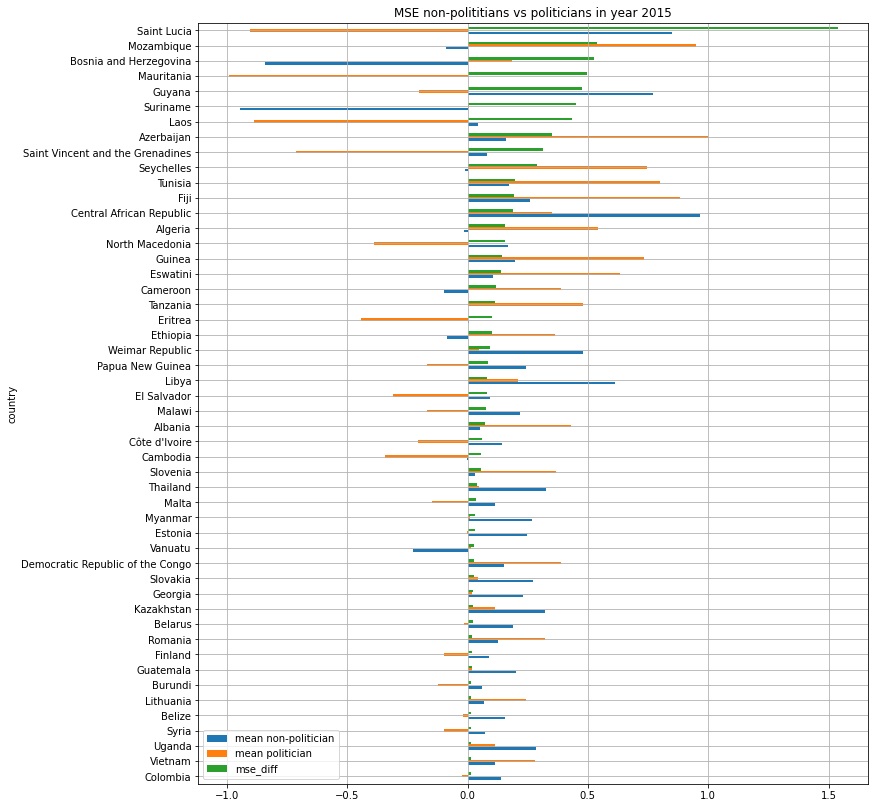

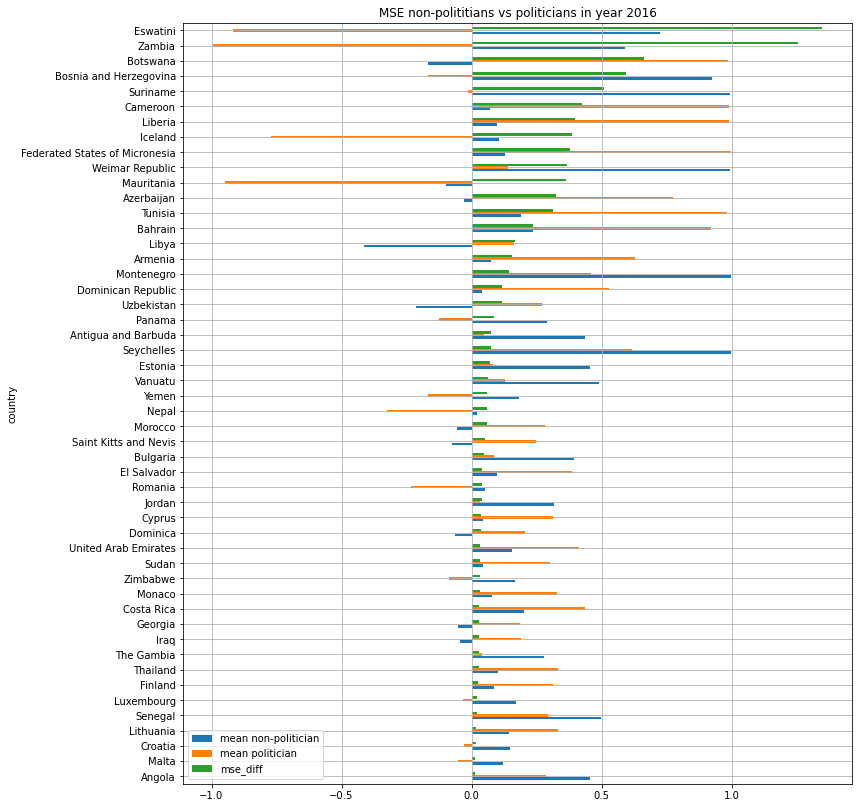

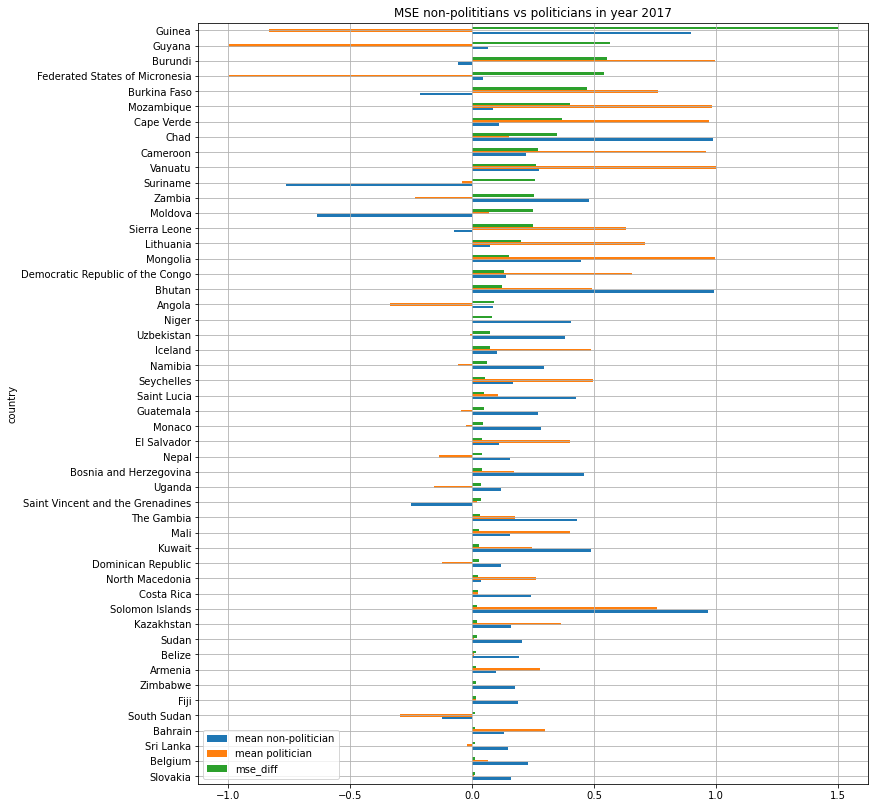

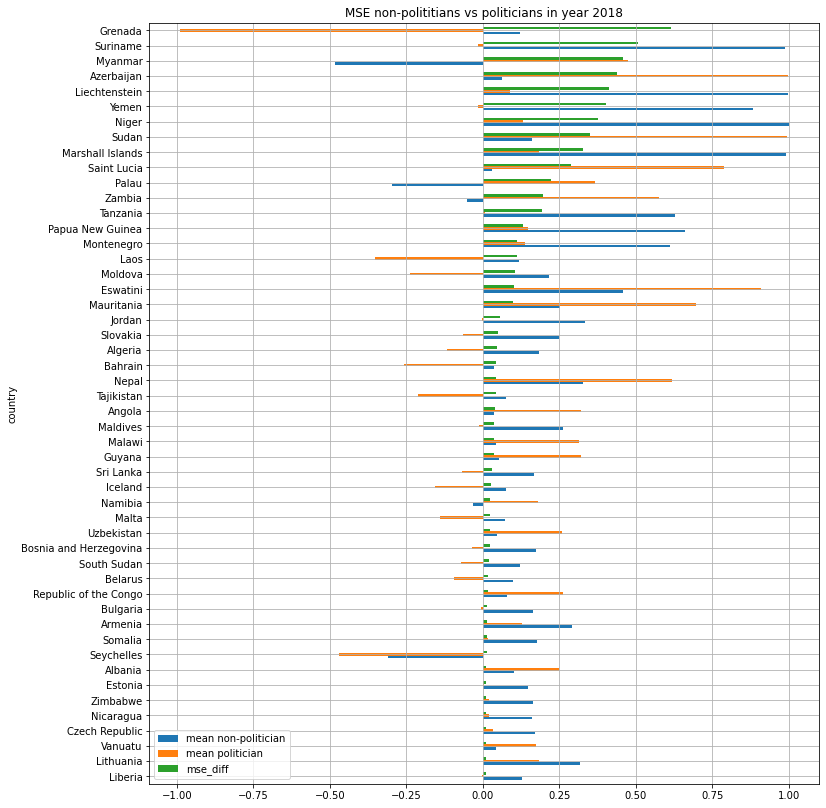

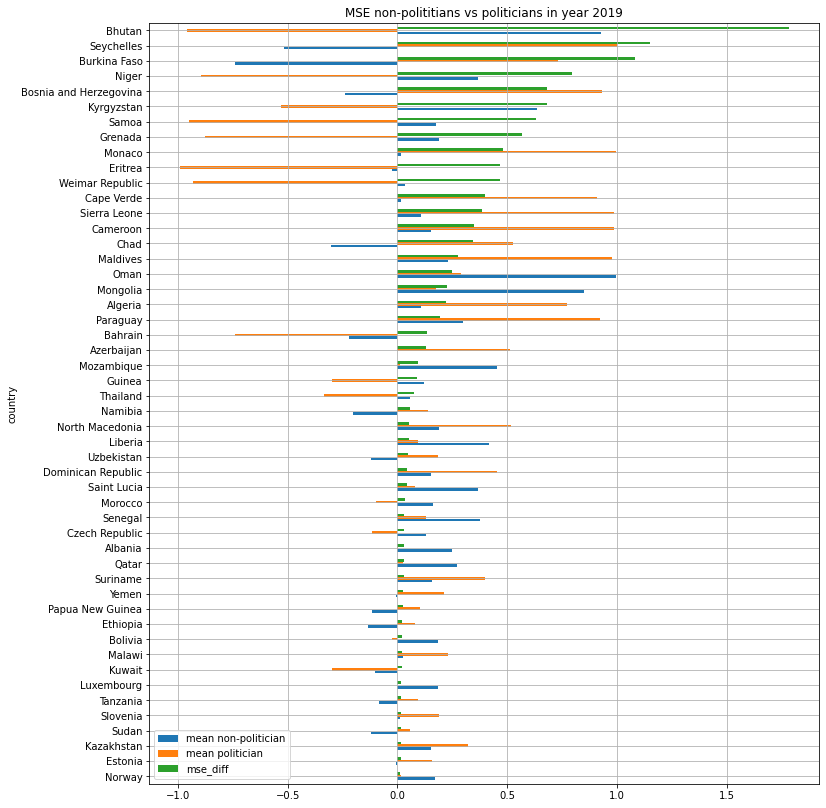

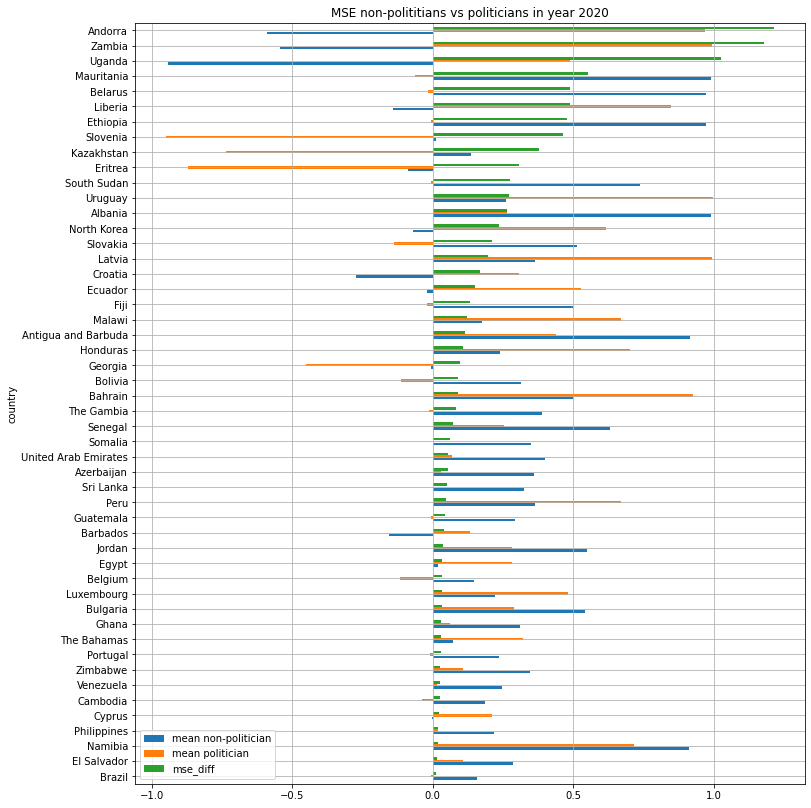

In [56]:
highest_diff = []
thres_diff = 0.25
for (ind, df) in enumerate(dfs_new) :

    pol_msk = df.politician == True

    df_country_non_p = df[~pol_msk].groupby("nationality")
    df_country_p = df[pol_msk].groupby("nationality")
    
    df_mean_non_p = compute_mean(df_country_non_p)
    df_mean_p = compute_mean(df_country_p)


    temp_df = pd.merge(left=df_mean_non_p, right=df_mean_p, left_on='country', right_on='country', suffixes=(' non-politician', ' politician'))

    temp_df['mse_diff'] = 1/2 * np.abs(temp_df['mean politician'] - temp_df['mean non-politician'])**2
    
    temp_df.sort_values('mse_diff',  ascending= True,inplace = True)
    
    temp_df.tail(50).plot(x= 'country', figsize=(12,14), kind='barh')
    plt.title("MSE non-polititians vs politicians in year " + str(ind + 2015))
    plt.grid()
    plt.show()
    
    highest_diff += temp_df[temp_df.mse_diff > thres_diff]['country'].tolist()

In [58]:
#Get the number of times a country appears in the top differences
diff_dict = {i:highest_diff.count(i) for i in highest_diff}
diff_dict = dict(sorted(diff_dict.items(), key=lambda item: item[1], reverse= True))
{k: v for k, v in diff_dict.items() if  v > 1}

{'Suriname': 4,
 'Azerbaijan': 3,
 'Mauritania': 3,
 'Bosnia and Herzegovina': 3,
 'Cameroon': 3,
 'Zambia': 3,
 'Seychelles': 2,
 'Guyana': 2,
 'Mozambique': 2,
 'Saint Lucia': 2,
 'Weimar Republic': 2,
 'Federated States of Micronesia': 2,
 'Liberia': 2,
 'Chad': 2,
 'Cape Verde': 2,
 'Burkina Faso': 2,
 'Niger': 2,
 'Grenada': 2,
 'Eritrea': 2}

### Pew comparison

In [14]:
import pyreadstat

In [15]:
column_names = ['country', 'fav_us', 'sex', 'age']

In [16]:
columns = {2015: ['COUNTRY', 'Q12A', 'Q145', 'Q146'], 
           2016: ['country', 'Q10A', 'q107', 'q108'], 
           2017: ['Country', 'fav_US', 'sex', 'age'], 
           2018: ['COUNTRY', 'fav_US', 'sex', 'age'], 
           2019: ['country', 'FAV_US', 'SEX', 'AGE'], 
           2020: ['country', 'fav_US', 'sex', 'age']}

In [25]:
pew = pd.read_csv('data/pew.csv')

#List of "invalid" answers in pew dataset
Nan_keywords = ['Refused', 'Don’t know', 'Don’t know (DO NOT READ)', 'Refused (DO NOT READ)',
       '(VOL) Refused', "(VOL)\xa0Don't know"]

pew = pew.replace(to_replace=Nan_keywords, value=np.NaN)

#map "sentiment" to float values
fav_dict = {'Somewhat favorable': 0.25, 'Very favorable':1,
       'Somewhat unfavorable':-0.25, 'Very unfavorable':-1}

pew = pew.replace(fav_dict)

In [26]:
pew.columns

Index(['country', 'fav_us', 'sex', 'age', 'year'], dtype='object')

In [27]:
pew.fav_us.unique()

array([ 0.25,  1.  ,   nan, -0.25, -1.  ])

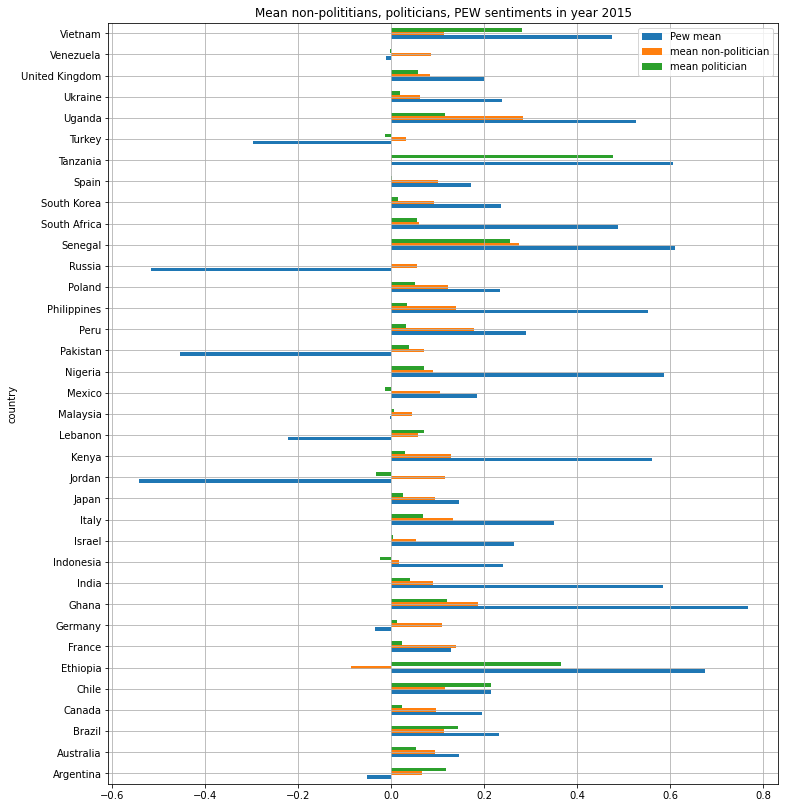

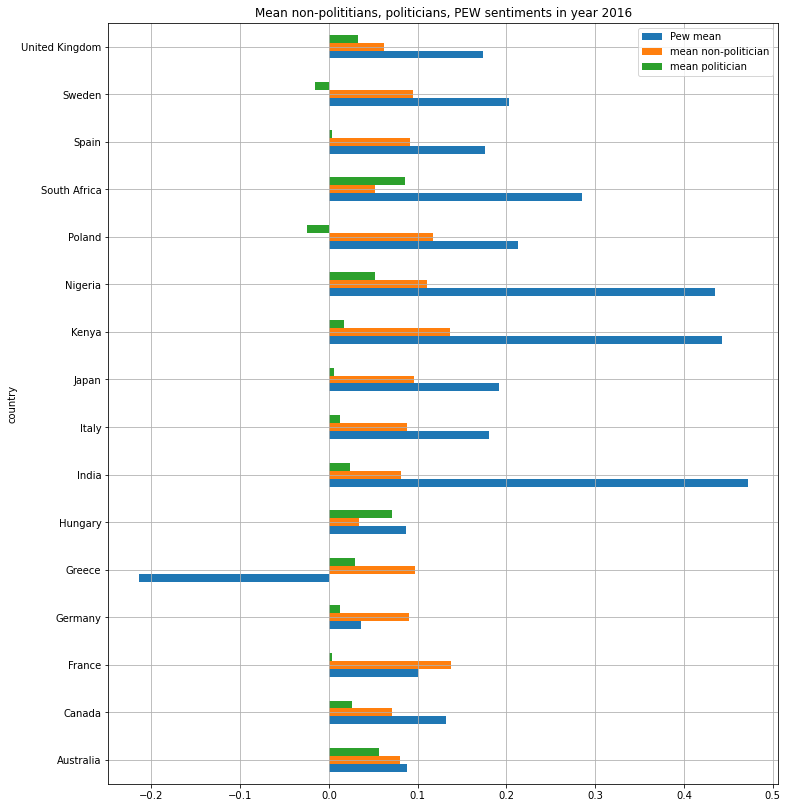

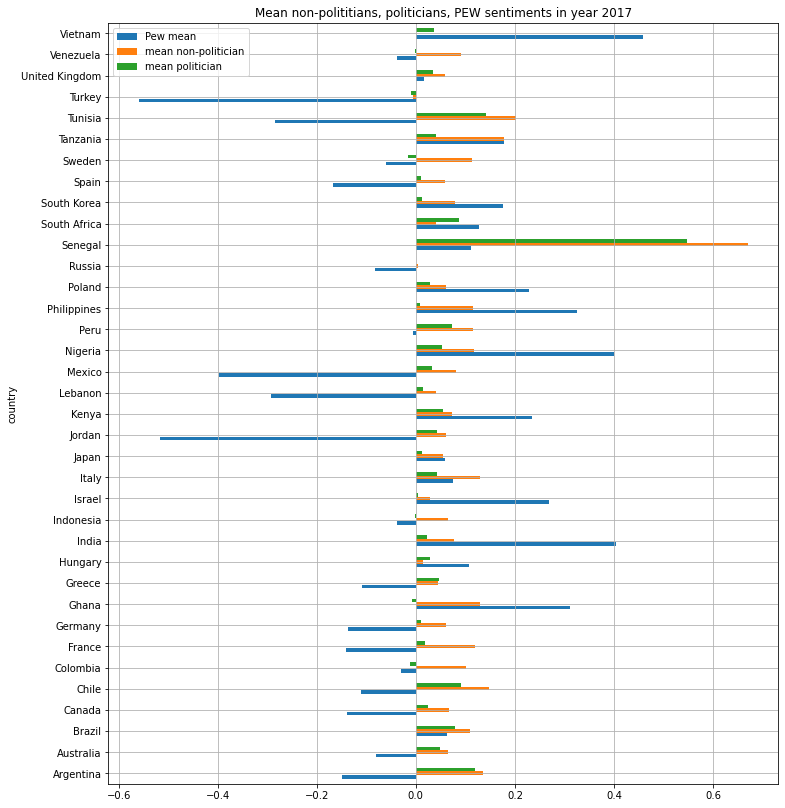

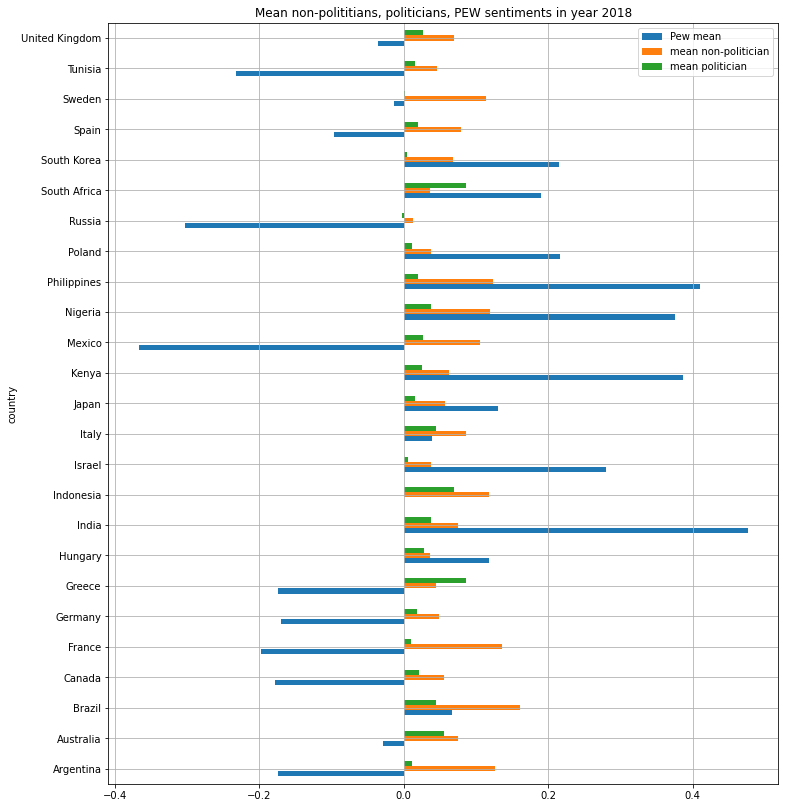

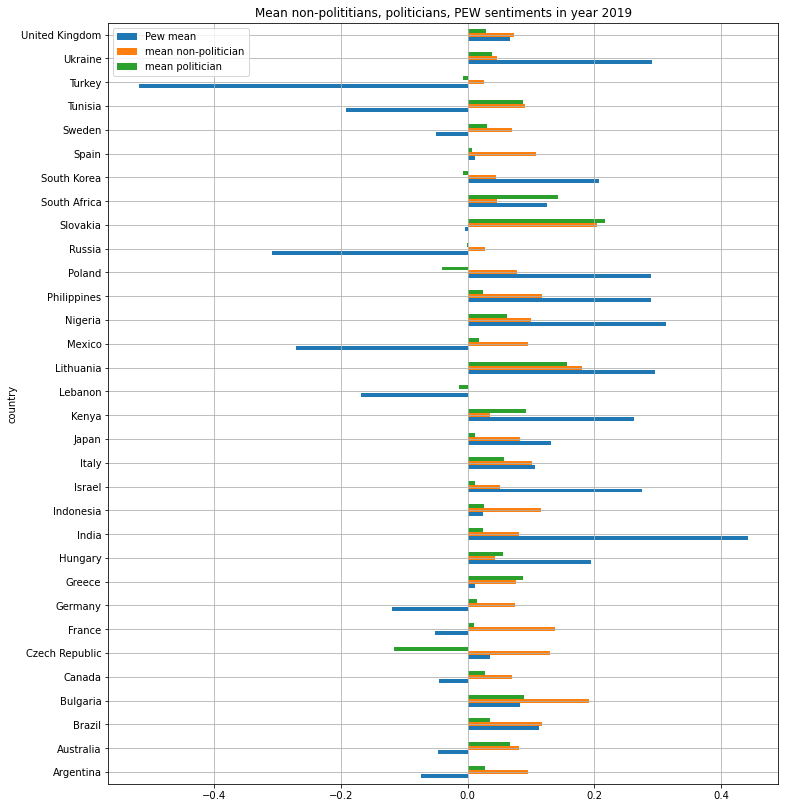

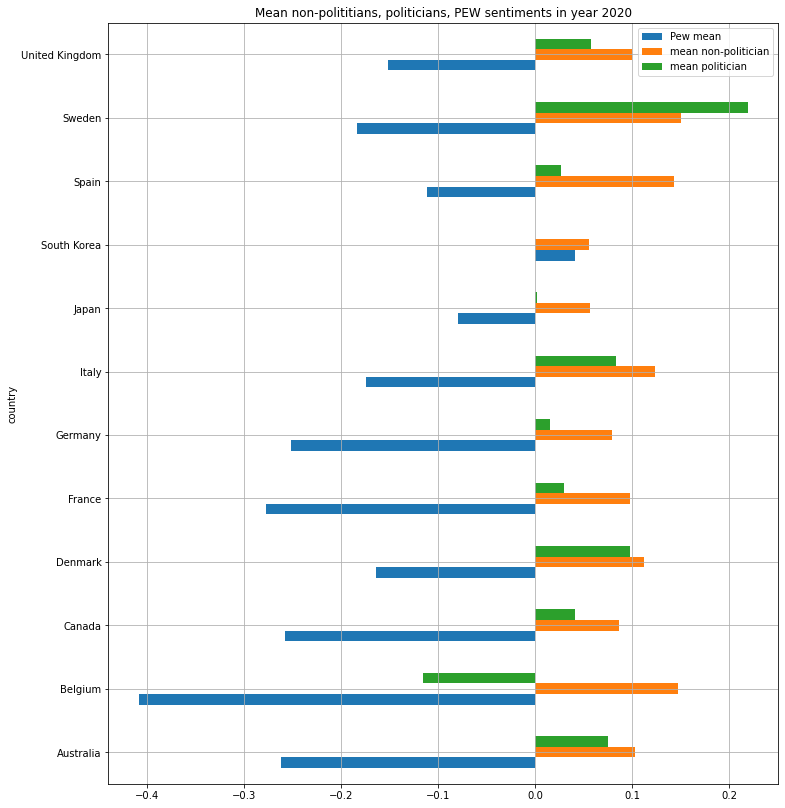

In [30]:

for (ind, df) in enumerate(dfs_new) :

    pol_msk = df.politician == True

    df_country_non_p = df[~pol_msk].groupby("nationality")
    df_country_p = df[pol_msk].groupby("nationality")
    
    df_mean_non_p = compute_mean(df_country_non_p)
    df_mean_p = compute_mean(df_country_p)
    pew_fav_us = pew[pew.year == (ind + 2015)].groupby('country')['fav_us'].mean().reset_index(name='Pew mean')


    temp_df = pd.merge(left=df_mean_non_p, right=df_mean_p, left_on='country', right_on='country', suffixes=(' non-politician', ' politician'))
    temp_df = pd.merge(left=pew_fav_us, right=temp_df, left_on='country', right_on='country')

    temp_df.plot(x= 'country', figsize=(12,14), kind='barh')
    plt.title("Mean non-polititians, politicians, PEW sentiments in year " + str(ind + 2015))
    plt.grid()
    plt.show()

In [67]:

from sklearn import metrics

In [68]:
mse_years_non_p = []
mse_years_p = []
for (ind, df) in enumerate(dfs_new) :

    pol_msk = df.politician == True

    df_country_non_p = df[~pol_msk].groupby("nationality")
    df_country_p = df[pol_msk].groupby("nationality")
    
    df_mean_non_p = compute_mean(df_country_non_p)
    df_mean_p = compute_mean(df_country_p)
    pew_fav_us = pew[pew.year == (ind + 2015)].groupby('country')['fav_us'].mean().reset_index(name='Pew mean')


    temp_df = pd.merge(left=df_mean_non_p, right=df_mean_p, left_on='country', right_on='country', suffixes=(' non-politician', ' politician'))
    temp_df = pd.merge(left=pew_fav_us, right=temp_df, left_on='country', right_on='country')
    

    temp_df['abs_diff_non_p'] = np.abs(temp_df['Pew mean'] - temp_df['mean non-politician'])
    temp_df['abs_diff_p'] = np.abs(temp_df['Pew mean'] - temp_df['mean politician'])
    temp_df.sort_values('abs_diff_non_p', inplace = True)

#     temp_df[['country','abs_diff_non_p', 'abs_diff_p']].plot(x= 'country', figsize=(12,14), kind='barh')
#     plt.title("Absolute difference mean (non)polititians w.r.t. PEW sentiments in year " + str(ind + 2015))
#     plt.grid()
#     plt.show()
    
    mse_years_non_p.append(metrics.mean_squared_error(temp_df['Pew mean'], temp_df['mean non-politician']))
    mse_years_p.append(metrics.mean_squared_error(temp_df['Pew mean'], temp_df['mean politician']))

In [69]:
mse_years_non_p

[0.11564369079766121,
 0.03575213001417866,
 0.07334061237986574,
 0.05622955515678644,
 0.0425981019011025,
 0.10279673840042548]

In [70]:
mse_years_p

[0.10291023288279459,
 0.054146453307127536,
 0.0663429055623694,
 0.05364067845144229,
 0.04247228936453803,
 0.06851675532760973]

In [71]:
np.array(mse_years_non_p) > np.array(mse_years_p)

array([ True, False,  True,  True,  True,  True])